## Preparations

### Imports

In [1]:
import numpy as np
from matplotlib.pyplot import get_cmap
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
from boston_ds import BostonDS
from drift_detection.drift_testers.ks_drift_tester import KsDriftTester
from helpers.data_helper import sample_from_data, change_int_values
from helpers.model_helper import XgbModel
from helpers.utils import calc_perf_kpis

from drift_detection.drift_detector import DriftDetector


D:\docs\Study\DSML_IDC\Semester5\MLOps\Project\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare Boston data for demo

In [2]:

# ============================================================= Initial data setup
# Load and prep boston data
boston = BostonDS()

x = boston.x
y = boston.y
x_cont_features = boston.cont_features
x_int_features = boston.int_features
x_cat_features = boston.cat_features

# from entire dataset, choose subset for initial train/test
TRAIN_TEST_SIZE = 520
x_sample, y_sample = sample_from_data(x, y, TRAIN_TEST_SIZE)
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.4, random_state=10)

display(x_train.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
1869,-0.035556,60.0,1.69,0,0.409099,6.579,35.974986,10.724969,4,411,18.3,370.78,5.49
531,0.789055,0.0,8.14,0,0.538033,5.599,85.411187,4.469717,4,307,21.0,303.42,16.51
1675,1.142353,0.0,19.58,0,0.605219,6.943,97.344514,1.875481,5,403,14.7,363.43,4.59
1159,2.272871,0.0,19.58,0,0.871278,4.926,95.478915,1.454917,5,403,14.7,391.71,29.53
472,3.540322,0.0,18.1,0,0.580339,6.437,74.602302,2.905269,24,666,20.2,393.37,14.36


## Train Step

### Model train

In [3]:

# ============================================================= Train step
# Build model on train data
model = XgbModel()
model.fit(x_train, y_train)


### Drift detector configuration and train

**Creates a drift detector and auto-select and fit drift testers based on feature types:**
* Numeric features - Kolmogorov–Smirnov tester
* Categorical tests - Chi^2 tester
* All together - KL Divergence (Multivariable) tester

All testers default with pval=0.005, with three conseq. failures.

In [4]:
# Create Feature drift detector with all default testers
drift_detector = DriftDetector()
drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
drift_detector.fit(x_train)

In [5]:
tests_in_detector = drift_detector.drift_test_set.get_test_names()
print('Testers in drif detector: ', len(tests_in_detector),'\n', tests_in_detector)

Testers in drif detector:  14 
 ['ks_CRIM', 'ks_ZN', 'ks_INDUS', 'ks_NOX', 'ks_RM', 'ks_AGE', 'ks_DIS', 'ks_PTRATIO', 'ks_B', 'ks_LSTAT', 'ks_RAD', 'ks_TAX', 'chi_CHAS', 'kl_div']


**In Advanced mode - user can select other testers, p-vals, conseq failures.**

Univariate testers:
* Kolmogorov–Smirnov
* Chi^2

Multivariate testers:
* Multivariate KL Divergence with autofit
* Multivariate MMD (Max Mean Divergence) with autofit
* Multivatiate KS over PCA


### Collect data for plots later

In [6]:
# Initial predction / drift test plan
y_pred = model.predict(x_test)
drift_test_results = drift_detector.test_drift(x_test)

In [7]:
# Calc and store initial model performance KPIs on test
kpi = calc_perf_kpis(x_test, y_test, y_pred)
kpi['drift_detected'] = drift_test_results['drift_detected']
kpi['test_exceptions'] = drift_test_results['test_exceptions']

perf_kpis = pd.DataFrame(columns=kpi.keys()).append(kpi, ignore_index=True)

## Runtime step

In [8]:
# ============================================================= Runtime step
number_of_batches = 300
start_drift_at_batch = 100
sample_size = 50


# Runtime loop
for i in range(number_of_batches):
    # Sample batch from data (No drift yet)
    x_sample, y_sample = sample_from_data(x, y, sample_size)

    # modify data batch to create feature drift
    if i > start_drift_at_batch:
        x_sample['RM'] = x_sample['RM'] + x['RM'].std() * 0.01 * (i - start_drift_at_batch)
        x_sample['LSTAT'] = x_sample['LSTAT'] + x['LSTAT'].std() * 0.01 * (i - start_drift_at_batch)
        x_sample = change_int_values(x_sample, 'CHAS', 0, 1, 0.01 * (i - start_drift_at_batch))


    # predict
    y_pred = model.predict(x_sample)

    # calc RMSE (For demo only, cannot do in real runtime - no labels there
    kpi_sample = calc_perf_kpis(x_sample, y_sample, y_pred)

    # Execute drift test
    drift_test_results = drift_detector.test_drift(x_sample)

    # Collect data for plots later on
    kpi_sample['drift_detected'] = drift_test_results['drift_detected']
    kpi_sample['test_exceptions'] = drift_test_results['test_exceptions']
    perf_kpis = perf_kpis.append(kpi_sample, ignore_index=True)


## Plot RMSE and detection results

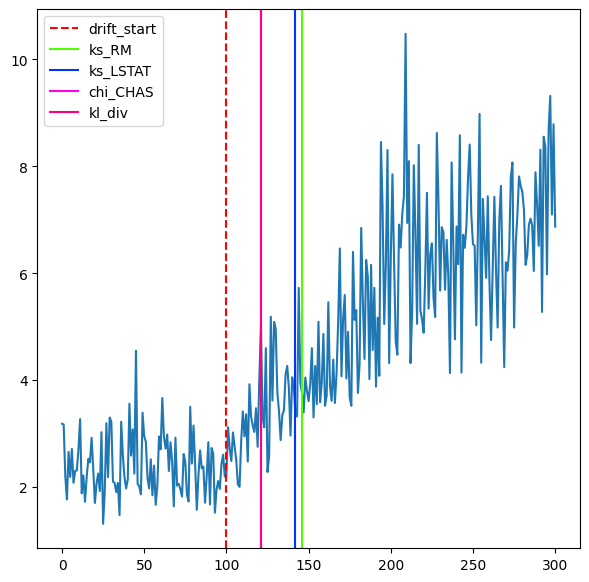

,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions
0,0.905393,0.899053,1.703821,1.703821,3.185339,False,[]
1,0.865824,0.817371,1.631339,1.631339,3.173137,False,[]
2,0.943340,0.922879,1.425792,1.425792,2.202601,False,[]
3,0.955162,0.938970,0.971684,0.971684,1.769425,False,[]
4,0.931235,0.906403,1.484512,1.484512,2.659733,False,[]
...,...,...,...,...,...,...,...
296,0.369608,0.141967,5.479348,5.479348,8.683787,True,"[ks_RM, ks_LSTAT, kl_div]"
297,0.155686,-0.149205,5.921305,5.921305,9.317363,True,"[ks_RM, ks_LSTAT, kl_div]"
298,0.372452,0.145837,5.235167,5.235167,7.099144,True,"[ks_RM, ks_LSTAT, kl_div]"
299,0.141010,-0.169181,5.635164,5.635164,8.786051,True,"[ks_RM, ks_LSTAT, kl_div]"


In [9]:

# ========================================================================== Plot

fig, axs = plt.subplots(figsize=(7, 7))

# plot RMSE (Loss function) line
axs.plot(perf_kpis['RMSE'])

# plot vertical lin for data drift start point
axs.axvline(x=start_drift_at_batch, label='drift_start', color='r', linestyle='dashed')

# Get drift detector x_history for plots
x_history = drift_detector.history_df

# plot vertical line for each tester that fired
fail_detections = []
cmap = get_cmap('hsv', 15)

for i, test_name in enumerate(drift_detector.get_test_names()):
    if x_history[test_name].sum() > 0:
        detection_time = np.where(x_history[test_name] == True)[0].min()
        axs.axvline(x=detection_time, label=test_name, color=cmap(i))

# Display plot
axs.legend()
plt.show()

display(perf_kpis)
